## Goal: Fit a time series model to the historical bitcoin daily closing values

1. [Simple Exponential Smoothing](#optparam1)
2. [Holt's Linear Trend Method](#optparam2)
3. [Damped Trend Method](#optparam3)
4. [Taxonomy of Exponential Smoothing Methods](#optparam4)


* Importing 'forecast' package which is very useful to model time series data
* As well as lattice package to use xyplot() function which is a simple function to plot time series in a neat way

In [1]:
library(forecast)
library(lattice)
list.files(path = "data/")

Warning message:
"package 'forecast' was built under R version 3.4.4"

[1] "test.csv"  "train.csv"

In [2]:
train = read.csv("data/train.csv", header=T)
test = read.csv("data/test.csv", header=T)

# glimpse of top few rows of train data

head(train)

Date,Open,High,Low,Close,Volume,Market.Cap
"Jul 31, 2017",2763.24,2889.62,2720.61,2875.34,"860,575,000","45,535,800,000"
"Jul 30, 2017",2724.39,2758.53,2644.85,2757.18,"705,943,000","44,890,700,000"
"Jul 29, 2017",2807.02,2808.76,2692.80,2726.45,"803,746,000","46,246,700,000"
"Jul 28, 2017",2679.73,2897.45,2679.73,2809.01,"1,380,100,000","44,144,400,000"
"Jul 27, 2017",2538.71,2693.32,2529.34,2671.78,"789,104,000","41,816,500,000"
"Jul 26, 2017",2577.77,2610.76,2450.80,2529.45,"937,404,000","42,455,000,000"


* We will predict the daily Closing value time series for future periods.
* The future data has for validation purposes in in the test data frame

In [3]:
head(test)

Date,Open,High,Low,Close,Volume,Market.Cap
"Aug 07, 2017",3212.78,3397.68,3180.89,3378.94,"1,482,280,000","52,987,300,000"
"Aug 06, 2017",3257.61,3293.29,3155.60,3213.94,"1,105,030,000","53,720,900,000"
"Aug 05, 2017",2897.63,3290.01,2874.83,3252.91,"1,945,700,000","47,778,200,000"
"Aug 04, 2017",2806.93,2899.33,2743.72,2895.89,"1,002,120,000","46,276,200,000"
"Aug 03, 2017",2709.56,2813.31,2685.14,2804.73,"804,797,000","44,666,400,000"
"Aug 02, 2017",2727.13,2762.53,2668.59,2710.67,"1,094,950,000","44,950,800,000"


* Creating **close_tr_df** as a data frame having dates and closing values in USD for **TRAIN** data
* Creating **close_val_df** as a data frame having dates and closing values in USD for **TEST** data



* We will also use the **mdy()** function from lubridate to convert Date column from factor to a POSIXCt object

In [4]:
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(lubridate))

train$Date <- mdy(train$Date)
test$Date <- mdy(test$Date)

close_tr_df <- train[,c("Date", "Close")] %>% arrange(Date)
close_val_df <- test[,c("Date", "Close")] %>% arrange(Date)
tail(close_tr_df)
head(close_val_df)

Warning message:
"package 'dplyr' was built under R version 3.4.3"Warning message:
"package 'lubridate' was built under R version 3.4.3"Warning message:
"package 'bindrcpp' was built under R version 3.4.4"

,Date,Close
1551,2017-07-26,2529.45
1552,2017-07-27,2671.78
1553,2017-07-28,2809.01
1554,2017-07-29,2726.45
1555,2017-07-30,2757.18
1556,2017-07-31,2875.34


Date,Close
2017-08-01,2718.26
2017-08-02,2710.67
2017-08-03,2804.73
2017-08-04,2895.89
2017-08-05,3252.91
2017-08-06,3213.94


* We can see that train data ends at July 31st 2017 while test data starts at August 1st 2017
* Lets see if we have any missing values

In [5]:
table(is.na(close_tr_df))
table(is.na(close_val_df))


FALSE 
 3112 


FALSE 
   14 

* No missing values



* Now using **ts() function and its START= and END=** arguments to create a **ts** object for TRAIN data and VALIDATION (TEST) DATA
* **ts** object is a time series object. We can do many flexible time series operations directly on this object
* We also plot the created ts object to see the pattern

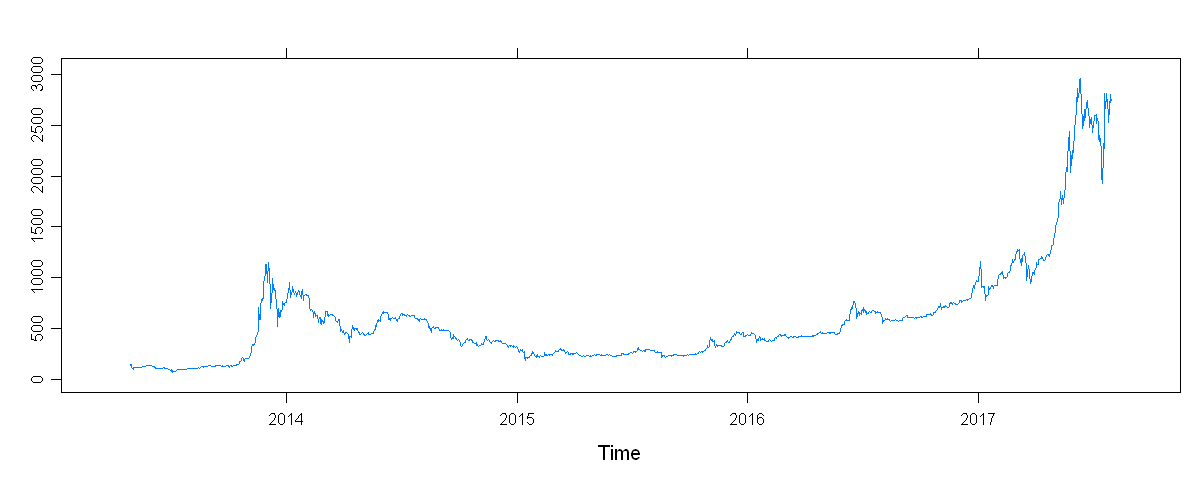

In [7]:
library(repr)
close_tr_ts <- ts(close_tr_df$Close,
                  start = c(as.numeric(format(close_tr_df$Date[1], "%Y")), as.numeric(format(close_tr_df$Date[1], "%j"))),
                  end = c(as.numeric(format(close_tr_df$Date[nrow(close_tr_df)], "%Y")), as.numeric(format(close_tr_df$Date[nrow(close_tr_df)], "%j"))),
                  frequency = 365)
close_val_ts <- ts(close_val_df$Close,
                  start = c(as.numeric(format(close_val_df$Date[1], "%Y")), as.numeric(format(close_val_df$Date[1], "%j"))),
                  end = c(as.numeric(format(close_val_df$Date[nrow(close_val_df)], "%Y")), as.numeric(format(close_val_df$Date[nrow(close_val_df)], "%j"))),
                  frequency = 365)
options(repr.plot.width=10 , repr.plot.height=4)
xyplot(close_tr_ts)

***
* There is a trend starting slowly from late 2015, increasing slowly till mid 2017 and very rapidly thereafter.
* Seasonality seems to be absent
* Non-stationary time series.


* **Forecasting approach from initial observations:**
    1. First we will start off by trying extremely basic models like naive forecast and drift.
    2. Then we will try out various exponential smoothing models starting with simple exponential smoothing and going on to ets with trend.
    3. We will also try ARIMA at the end.


In [8]:
naive_close <- naive(close_tr_ts, h = nrow(close_val_df))
drift_close <- rwf(close_tr_ts, h = nrow(close_val_df), drift = T)

cat("1 step Naive model")
accuracy(naive_close, close_val_ts)
cat("Drift model i.e. First observation - Last observation")
accuracy(drift_close, close_val_ts)

1 step Naive model

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,1.687883,37.1248,16.54763,0.1035267,2.589161,0.03643976,-0.02139786,NA
Test set,239.297143,351.7594,263.70571,7.3128706,8.212188,0.58071007,0.57328202,2.102406


Drift model i.e. First observation - Last observation

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,8.381870e-12,37.08641,16.5874,-0.4063651,2.630292,0.03652735,-0.02139786,NA
Test set,2.325456e+02,344.82320,258.4009,7.0950805,8.047721,0.56902835,0.57220176,2.060728


* Both the models are yielding almost similar results.
* We that see that we are heavily overfitting the train data for both models. This is because the right at the end of the train time series, there is a severe trend and the whole range of the time series has changed.
* This provides more evidence that exponential smoothing models might provide a reasonable estimate as we can weight the recent observations more in that.
* Let us try **Exponential Smoothing models**
<a id="optparam1"></a>



## 1. Simple Exponential Smoothing


In [9]:
close_ses <- ses(close_tr_ts)
summary(close_ses)


Forecast method: Simple exponential smoothing

Model Information:
Simple exponential smoothing 

Call:
 ses(y = close_tr_ts) 

  Smoothing parameters:
    alpha = 0.9799 

  Initial states:
    l = 134.3295 

  sigma:  37.1296

     AIC     AICc      BIC 
22672.88 22672.89 22688.93 

Error measures:
                   ME     RMSE      MAE       MPE     MAPE       MASE
Training set 1.720947 37.10568 16.53901 0.1054994 2.586803 0.03642078
                     ACF1
Training set -0.001713561

Forecasts:
          Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
2017.5808       2756.594 2709.011 2804.178 2683.822 2829.367
2017.5836       2756.594 2689.974 2823.214 2654.708 2858.481
2017.5863       2756.594 2675.278 2837.910 2632.232 2880.956
2017.5890       2756.594 2662.859 2850.330 2613.238 2899.950
2017.5918       2756.594 2651.903 2861.286 2596.482 2916.707
2017.5945       2756.594 2641.989 2871.200 2581.320 2931.868
2017.5973       2756.594 2632.867 2880.322 2567.370 2945.819
2017.6

* **ses()** function minimizes the SSE to estimate the right value of ALPHA and INITIAL STATE "L0"
* Looking at the summary, the ideal values for ALPHA and L0 are selected as 0.9798 and 134.2529 respectively
* Lets look at our performance on test data

In [10]:
close_ses_preds = data.frame(predict(close_ses, h= nrow(close_val_df)))
accuracy(close_ses_preds$Point.Forecast, close_val_ts)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,239.8828,352.1581,263.9567,7.332558,8.219547,0.573282,2.104888


* The model is still not performing efficiently. RMSE for test set is still $ 352 which was nearly the same as the one obtained by Naive model
* Factors like optimal **Alpha being 0.97** & **Naive model performing equally well as exponential smoothing** tends to suggest that the **observations in the recent past are more important when predicting Bitcoin Closing values**

* Note that we still haven't accomodated a model component for trend.
* We can definitely see that trend starts from late 2015 and is pretty much persistent throughout until the end
* So let us try to accomodate this trend
<a id="optparam2"></a>

## 2. Holt's linear trend method

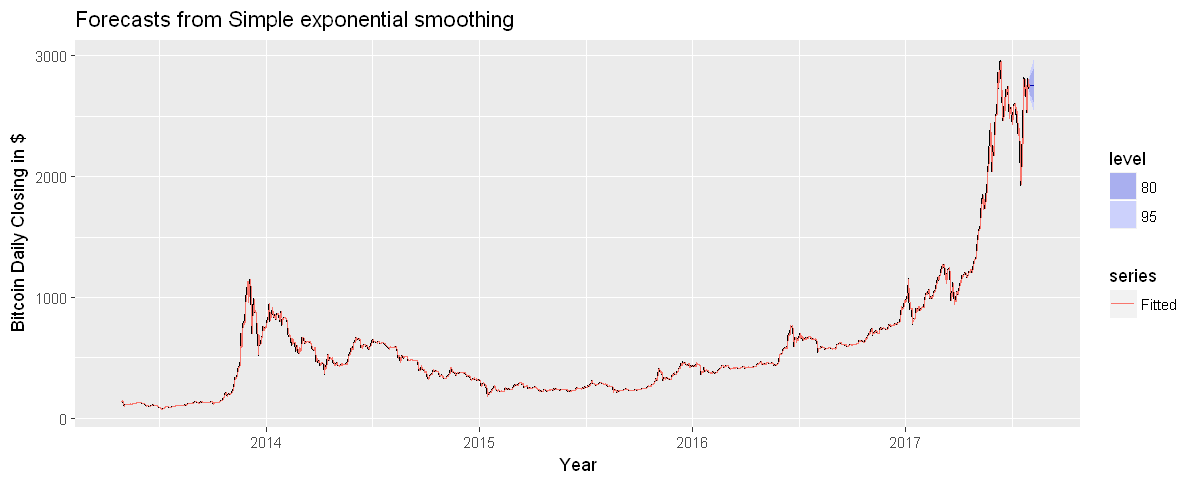

In [11]:
library(repr)
options(repr.plot.width =10, repr.plot.height=4)

autoplot(close_ses) +
  autolayer(fitted(close_ses), series="Fitted") +
  ylab("Bitcoin Daily Closing in $") + xlab("Year")

In [15]:
close_holt_lt <- holt(close_tr_ts)
summary(close_holt_lt)


Forecast method: Holt's method

Model Information:
Holt's method 

Call:
 holt(y = close_tr_ts) 

  Smoothing parameters:
    alpha = 0.9735 
    beta  = 0.0035 

  Initial states:
    l = 138.194 
    b = 0.7433 

  sigma:  37.1073

     AIC     AICc      BIC 
22673.01 22673.05 22699.75 

Error measures:
                   ME     RMSE     MAE          MPE     MAPE       MASE
Training set 0.900354 37.05951 16.4525 -0.008326569 2.583958 0.03623029
                     ACF1
Training set 8.804001e-05

Forecasts:
          Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
2017.5808       2762.285 2714.730 2809.840 2689.556 2835.014
2017.5836       2767.996 2701.510 2834.482 2666.315 2869.677
2017.5863       2773.707 2692.497 2854.916 2649.508 2897.906
2017.5890       2779.417 2685.687 2873.147 2636.070 2922.765
2017.5918       2785.128 2680.288 2889.968 2624.789 2945.468
2017.5945       2790.839 2675.888 2905.789 2615.037 2966.640
2017.5973       2796.549 2672.245 2920.854 2606.442 2986.

In [17]:
close_holt_lt_preds = data.frame(predict(close_holt_lt, h= nrow(close_val_df)))
accuracy(close_holt_lt_preds$Point.Forecast, close_val_ts)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,217.0598,328.8001,246.0173,6.596363,7.663347,0.5693948,1.964626


* RMSE has reduced by $ 30

* In Holt's linear trend method, all the future forecasts are either trended up or trended down constantly.
* This is not practical for most real-life datasets since some time or the other in the future, the trend will flatten.
* To accomodate this, there is a method called as DAMPED LINEAR TREND
* DAMPED LINEAR TREND method is very similar to Holt's method just with an additional dampening parameter which slowly reduces the trend of forecasts.
* Short term forecasts are trended in this method and long-term forecasts are flattened.
<a id="optparam3"></a>

## 3. Damped Trend Method

In [18]:
close_holt_damped <- holt(close_tr_ts, damped=TRUE, phi=0.8)
close_holt_damped

          Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
2017.5808       2756.605 2708.976 2804.234 2683.763 2829.448
2017.5836       2756.612 2689.922 2823.301 2654.619 2858.605
2017.5863       2756.617 2675.212 2838.022 2632.119 2881.115
2017.5890       2756.621 2662.780 2850.463 2613.103 2900.140
2017.5918       2756.625 2651.811 2861.439 2596.326 2916.924
2017.5945       2756.627 2641.885 2871.370 2581.145 2932.110
2017.5973       2756.630 2632.752 2880.507 2567.175 2946.084
2017.6000       2756.631 2624.247 2889.016 2554.167 2959.096
2017.6027       2756.633 2616.255 2897.010 2541.944 2971.321
2017.6055       2756.634 2608.695 2904.573 2530.381 2982.887

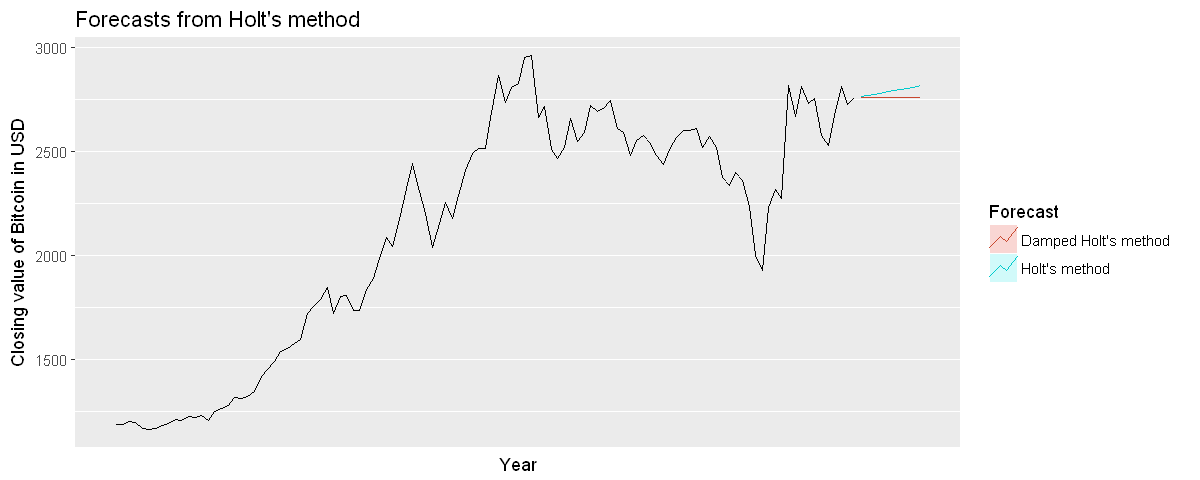

In [19]:
autoplot(window(close_tr_ts, start=c(2017,100))) +
  autolayer(close_holt_lt, series="Holt's method", PI=FALSE) +
  autolayer(close_holt_damped, series="Damped Holt's method", PI=FALSE) +
  ggtitle("Forecasts from Holt's method") + xlab("Year") +
  ylab("Closing value of Bitcoin in USD") +
  guides(colour=guide_legend(title="Forecast"))

In [20]:
close_holt_damped_preds = data.frame(predict(close_holt_damped, h= nrow(close_val_df)))
accuracy(close_holt_damped_preds$Point.Forecast, close_val_ts)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,239.8575,352.1354,263.9395,7.331729,8.219017,0.5732792,2.10475


* RMSE did not improve at all for Point.Forecast
* Interestingly, I tried checking the accuracy with Upper 95% Confidence boundary and the RMSE reduced extensively.
* This suggests that our model is under-estimating the trend and dampening is not a good option here.
* Lets see if we can correct this in future models

In [21]:
accuracy(close_holt_damped_preds$Hi.95, close_val_ts)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,101.5592,244.8846,198.6328,2.784298,6.332324,0.5566559,1.45503


<a id="optparam4"></a>

## 4. Taxonomy of Exponential Smoothing Methods

* There are multiple combinations of Exponential Smoothing models available to us.
* Models with trend, seasonal and level components with either of the components absent/present/additive/multiplicative.
* **ets()** function takes in a 'ts' object and estimates the best component driven Exponential Smoothing method among several options available

In [22]:
close_ets <- ets(close_tr_ts, damped=FALSE, allow.multiplicative.trend=TRUE)
close_ets

Warning message in ets(close_tr_ts, damped = FALSE, allow.multiplicative.trend = TRUE):
"I can't handle data with frequency greater than 24. Seasonality will be ignored. Try stlf() if you need seasonal forecasts."

ETS(M,M,N) 

Call:
 ets(y = close_tr_ts, damped = FALSE, allow.multiplicative.trend = TRUE) 

  Smoothing parameters:
    alpha = 0.9473 
    beta  = 0.0218 

  Initial states:
    l = 138.5493 
    b = 0.9992 

  sigma:  0.0424

     AIC     AICc      BIC 
20508.17 20508.21 20534.92 

In [23]:
close_ets_preds = data.frame(predict(close_ets, h= nrow(close_val_df)))
accuracy(close_ets_preds$Point.Forecast, close_val_ts)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,169.6478,281.2822,209.8717,5.067698,6.548465,0.5587581,1.680426


* Finally a BIG improvement w.r.t Point.Forecast
* Our last best RMSE for point forecast was $ 328
* ets() chose an Exponential Smoothing model with Multiplicative Level, Multiplicative Trend and Seasonality Absent.
* Note that we had set the trend dampening to be FALSE, let us set it to be true, although intuitively is should not help because our previous model was under-estimating the values.
* Before that lets quickly check the RMSE with Upper 95 CL as our forecasts

In [24]:
accuracy(close_ets_preds$Hi.95, close_val_ts)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-305.036,322.8162,305.036,-10.48964,10.48964,0.225983,2.014339


* RMSE has increased for Upper 95 CL. This is good. This means our model has improved and not under-estimated the forecasts.
* Although, I soon found out that there is still some under estimation as Upper 80 CL gives an RMSE below 200.
* This might be an indication that in the validation data we have, the values are slightly inflated. If we use Higher 80 CL, it might indicate an overfit of the current validation data.
* So sticking to Point Forecasts as our actual forecasts will still be a better decision.

In [25]:
accuracy(close_ets_preds$Hi.80, close_val_ts)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-128.1982,193.1998,165.9069,-4.70026,5.83816,0.4495235,1.192402


* Foolowing is Search for best Component Exponential Smoothing model with **trend DAMPNING**
* As expected, the model does not help much.

In [26]:
close_ets_damped <- ets(close_tr_ts, damped=TRUE, allow.multiplicative.trend=TRUE)
close_ets_damped_preds = data.frame(predict(close_ets_damped, h= nrow(close_val_df)))
accuracy(close_ets_damped_preds$Point.Forecast, close_val_ts)

Warning message in ets(close_tr_ts, damped = TRUE, allow.multiplicative.trend = TRUE):
"I can't handle data with frequency greater than 24. Seasonality will be ignored. Try stlf() if you need seasonal forecasts."

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,201.227,312.9744,233.6084,6.085012,7.278193,0.5662424,1.869645


<a id="optparam5"></a>

## 5. ARIMA Modelling

* So the best results thus far has been ETS(M,M,N) Model - $ 281 RMSE.
* Let us try to better it using ARIMA models.
* ARIMA models use the past observations and past errors to create extremely flexible forecasting systems
* We will use a non-seasonal ARIMA model

In [27]:
(close_arima <- auto.arima(close_tr_ts))

Series: close_tr_ts 
ARIMA(3,2,0) 

Coefficients:
          ar1      ar2      ar3
      -0.7579  -0.5192  -0.2873
s.e.   0.0243   0.0283   0.0245

sigma^2 estimated as 1730:  log likelihood=-7992.15
AIC=15992.3   AICc=15992.32   BIC=16013.69

In [28]:
close_arima_preds = close_arima %>% forecast(h= nrow(close_val_df)) %>% data.frame()
accuracy(close_arima_preds$Point.Forecast, close_val_ts)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,88.00693,219.4182,179.0843,2.391043,5.721041,0.5410355,1.309949


* We can see that AUTO.ARIMA() selected an ARIMA model with p = 3, d = 2 and q = 0.
* RMSE is also the best we have had so far, $ 220.

#### In the second notebook we will try to
1. Come up with our own ARIMA parameters and see if the performance increases
2. run LSTM Neural Networks to see if the performance increases